In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [12]:
daily_summary = pd.read_parquet('../clean_data/avg_global.parquet')

In [13]:
results = []
splits = np.arange(0.2, 0.51, 0.01)

for test_size in splits:
    train, test = train_test_split(
        daily_summary['tasa_excepcion'], test_size=test_size, shuffle=False
    )

    model = ExponentialSmoothing(
        train,
        trend='add',
        seasonal='add',
        seasonal_periods=14,
        initialization_method='estimated',
        use_boxcox=False,
        freq='D',
    ).fit()

    forecast = model.forecast(steps=len(test))

    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)

    test_diff = np.diff(test)
    forecast_diff = np.diff(forecast)
    min_len = min(len(test_diff), len(forecast_diff))
    test_diff_aligned = test_diff[:min_len]
    forecast_diff_aligned = forecast_diff[:min_len]
    da = np.mean((np.sign(test_diff_aligned) == np.sign(forecast_diff_aligned)).astype(int)) * 100

    train_mean = train.mean()
    mean_forecast = np.full(len(test), train_mean)
    mae_mean = mean_absolute_error(test, mean_forecast)
    mse_mean = mean_squared_error(test, mean_forecast)
    mean_forecast_diff = np.diff(mean_forecast)
    min_len_mean = min(len(test_diff), len(mean_forecast_diff))
    da_mean = np.mean((np.sign(test_diff[:min_len_mean]) == np.sign(mean_forecast_diff[:min_len_mean])).astype(int)) * 100

    results.append({
        'split': test_size,
        'mae': mae,
        'mse': mse,
        'da': da,
        'mae_mean': mae_mean,
        'mse_mean': mse_mean,
        'da_mean': da_mean
    })

results_df = pd.DataFrame(results)


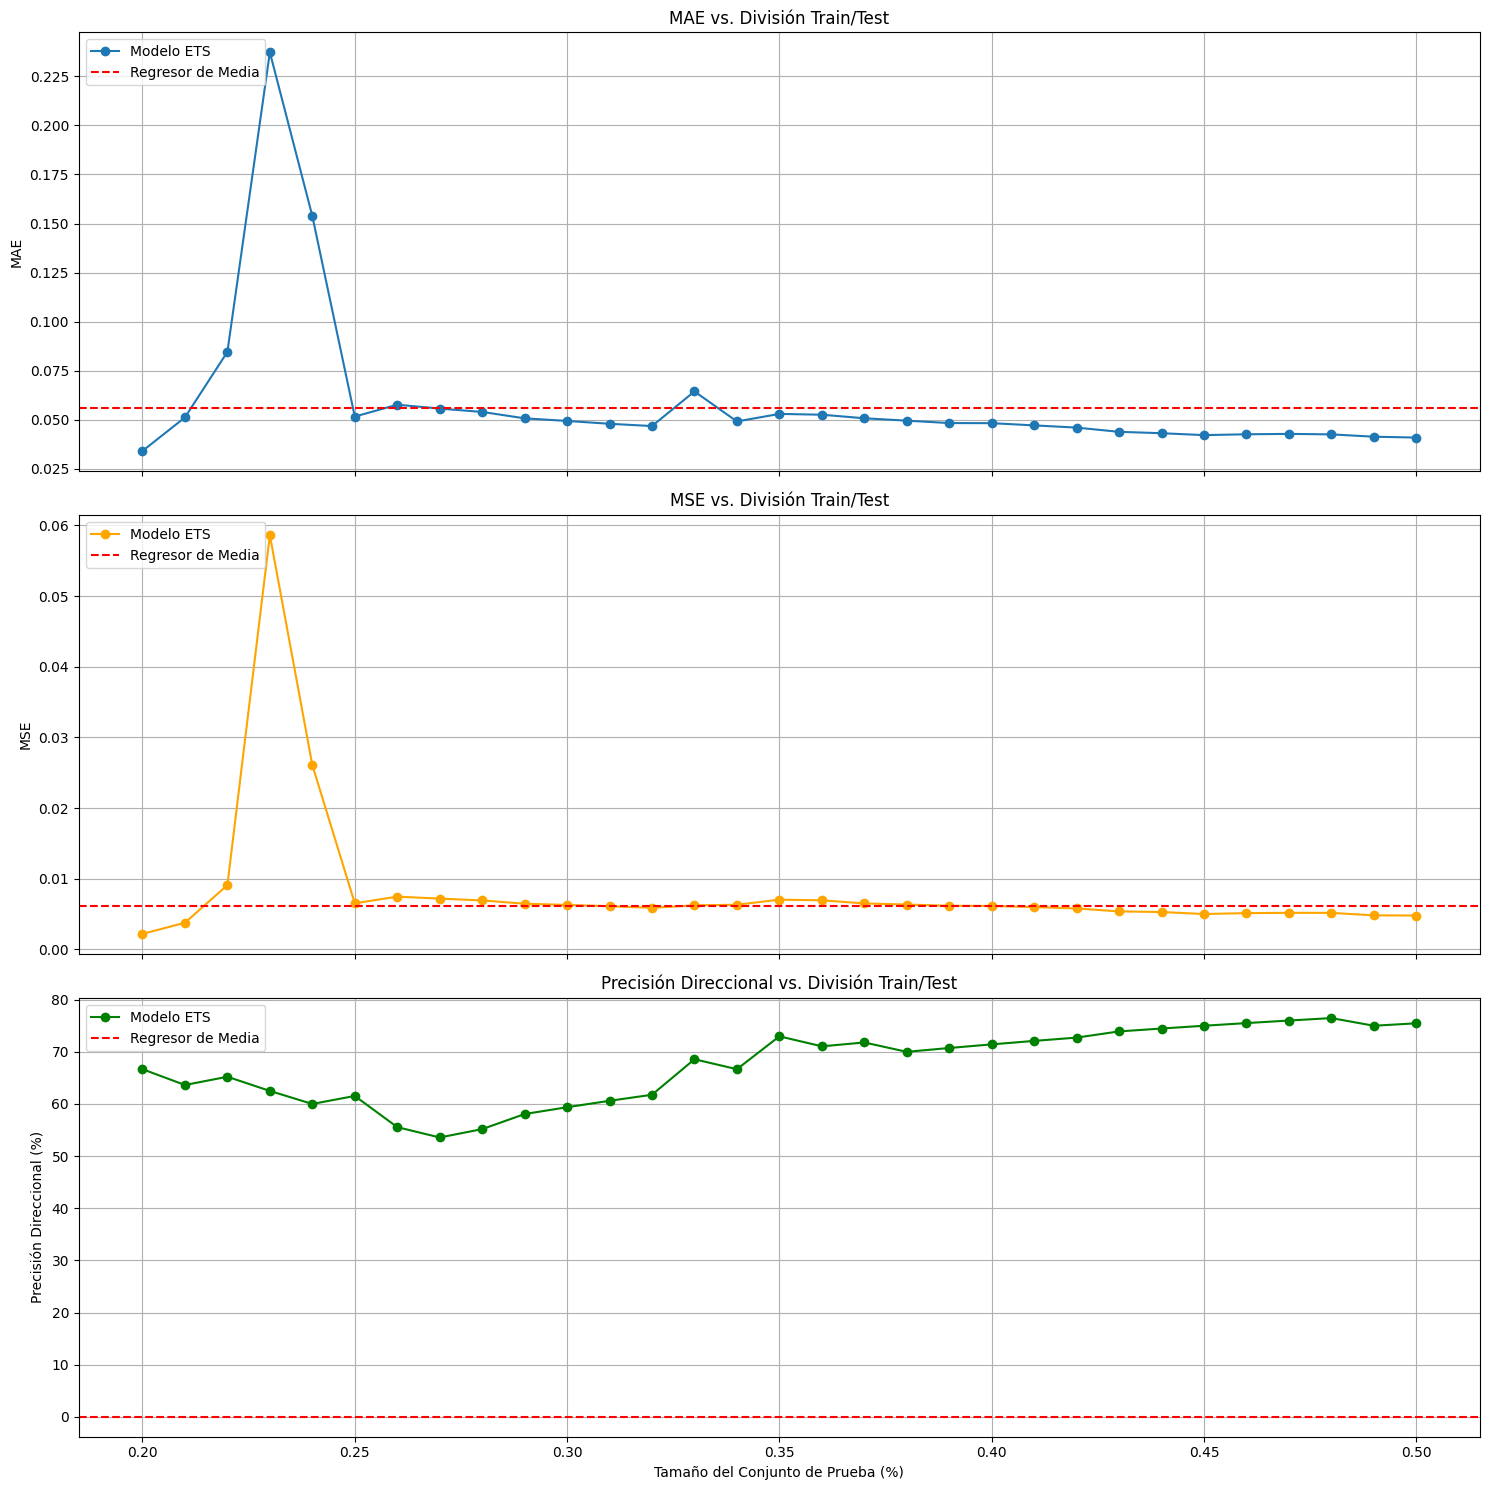

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

axes[0].plot(results_df['split'], results_df['mae'], marker='o', linestyle='-', label='Modelo ETS')
axes[0].axhline(y=results_df['mae_mean'].mean(), color='r', linestyle='--', label='Regresor de Media')
axes[0].set_title('MAE vs. División Train/Test')
axes[0].set_ylabel('MAE')
axes[0].grid(True)
axes[0].legend(loc='upper left')

axes[1].plot(results_df['split'], results_df['mse'], marker='o', linestyle='-', color='orange', label='Modelo ETS')
axes[1].axhline(y=results_df['mse_mean'].mean(), color='r', linestyle='--', label='Regresor de Media')
axes[1].set_title('MSE vs. División Train/Test')
axes[1].set_ylabel('MSE')
axes[1].grid(True)
axes[1].legend(loc='upper left')

axes[2].plot(results_df['split'], results_df['da'], marker='o', linestyle='-', color='green', label='Modelo ETS')
axes[2].axhline(y=results_df['da_mean'].mean(), color='r', linestyle='--', label='Regresor de Media')
axes[2].set_title('Precisión Direccional vs. División Train/Test')
axes[2].set_ylabel('Precisión Direccional (%)')
axes[2].set_xlabel('Tamaño del Conjunto de Prueba (%)')
axes[2].grid(True)
axes[2].legend(loc='upper left')

plt.tight_layout()
plt.savefig('../images/metricas_vs_division.png', dpi=150)
plt.show()


In [15]:
pd.DataFrame(results).da.mean()

67.53359125844418